---
# <center>**IOT INF730 - Projet Geolocalisation**</center>
---

## **Groupe :**
* *Philippe Bénézeth*
* *Xavier Bracquart*
* *Thomas Koch*
* *Nicolas Louis*
---

## **Objectifs :**
* Construire la matrice des features
* Construire la vérité terrain
* Tracer la probabilité d'erreur cumulative
* Calculer le critère de prédiction avec l'erreur à 80%
* Extraire la prédiction sur les données de test
* Enregistrer le résultat dans un fichier `.csv`
* Utiliser une validation croisée avec une stratégie de « leave 1 device out »
---

What kind of ML problems do we have ?
> On est sur un problème de régression.

What is the feature matrix / Ground truth ?
> Voir slide 34 du cours.

What kind of algorithm will we use ?
> Plusieurs alogorithmes du type supervisés sont possibles.
---
## **Initialisation**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

#pd.set_option('display.max_columns', 300)

---
## **1. Exploration des données**
### 1.1 Chargement des données

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

# nbr d'observations
print("nbr d'observations du train", df_mess_train.shape[0])
print("nbr d'observations du test", df_mess_test.shape[0])

### 1.2 Exploration des différents dataframe obtenus
#### Données d'entraînement

In [3]:
# Training set
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [5]:
df_mess_train.isnull().sum(axis = 0) #On regarde les NaN du df

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

#### Données de test

In [6]:
# Testing set
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [7]:
df_mess_test.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,29286.000000,29286.00000,29286.000000,29286.000000,2.928600e+04,29286.000000,29286.000000
mean,4643.290651,411306.93263,1.043075,-125.742454,1.472354e+12,42.332918,-101.228888
std,2578.625841,134472.75089,0.611285,8.861454,5.101975e+09,7.517469,11.198741
min,1012.000000,110335.00000,0.000000,-151.000000,1.463542e+12,36.528704,-110.957181
25%,2846.000000,472397.00000,1.000000,-132.000000,1.468001e+12,39.734330,-105.077530
50%,3563.000000,472504.00000,1.000000,-127.000000,1.472920e+12,39.777690,-105.045347
75%,7456.000000,472533.00000,1.500000,-121.000000,1.476688e+12,39.807916,-105.008827
max,11007.000000,473287.00000,2.000000,-63.000000,1.481142e+12,64.300000,-68.500000


In [8]:
df_mess_test.isnull().sum(axis = 0) #On regarde les NaN du df

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

In [9]:
# Label set
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [10]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [11]:
pos_train.isnull().sum(axis = 0) #On regarde les NaN du df

lat    0
lng    0
dtype: int64

> Pour simplifier la visualisation et la création de notre matrice de features, nous associons l'actuelle table des features à celle des positions (donc des labels). Nous réunissons également les datas de train et test pour faciliter l'exploration globale.

In [12]:
# On commence par joindre la table des features à celle des positions
df_mess_train[['pos_lat', 'pos_lng']] = pos_train

In [13]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


In [14]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289


In [ ]:
# on réunit les data de train et de test
df_mess = pd.concat([df_mess_train, df_mess_test])

### 1.3 Valeurs uniques
> Repérons le nombre de valeurs uniques pour `df_mess_train`, `df_mess_test` et `df_mess` (réunion des deux). On utilise pour cela la méthode `.nunique` de `pandas`.

In [15]:
print('--- Données d\'entraînements ---\n')
print("Nombre de messages uniques : %d" %df_mess_train.messid.nunique())
print("Nombre de stations uniques : %d" %df_mess_train.bsid.nunique())
print("Nombre de devices uniques : %d" %df_mess_train.did.nunique())
print("Nombre de valeurs uniques de time_ux : %d" %df_mess_train.time_ux.nunique())
print("Nombre de valeurs uniques de rssi : %d" %df_mess_train.rssi.nunique())
print("Nombre de valeurs uniques de nseq: %d" %df_mess_train.nseq.nunique())
print("Nombre de valeurs uniques de bs_lat : %d" %df_mess_train.bs_lat.nunique())
print("Nombre de valeurs uniques de bs_lng: %d" %df_mess_train.bs_lng.nunique())
print("Nombre de valeurs uniques de poslat: %d" %pos_train.lat.nunique())
print("Nombre de valeurs uniques de poslng: %d" %pos_train.lng.nunique())

--- Données d'entraînements ---

Nombre de messages uniques : 6068
Nombre de stations uniques : 251
Nombre de devices uniques : 113
Nombre de valeurs uniques dans time_ux : 6067
Nombre de valeurs uniques de rssi : 276
Nombre de valeurs uniques de nseq: 5
Nombre de valeurs uniques de bs_lat : 221
Nombre de valeurs uniques de bs_lng: 221


> On remarque ici que :
* 2 messages on le même `time_ux`.
* Il y a plus de `pos_lat` que de messages ce qui implique que nous devrons par exemple moyenner lors de la réunion des deux.

In [16]:
print('--- Données de test ---\n')
print("Nombre de messages uniques : %d" %(df_mess_test.messid.nunique()))
print("Nombre de stations uniques : %d" %(df_mess_test.bsid.nunique()))
print("Nombre de devices uniques : %d" %(df_mess_test.did.nunique()))
print("Nombre de valeurs uniques dans time_ux : %d" %(df_mess_test.time_ux.nunique()))
print("Nombre de valeurs uniques de rssi : %d" %(df_mess_test.rssi.nunique()))
print("Nombre de valeurs uniques de nseq: %d" %(df_mess_test.nseq.nunique()))
print("Nombre de valeurs uniques de bs_lat : %d" %df_mess_test.bs_lat.nunique())
print("Nombre de valeurs uniques de bs_lng: %d" %df_mess_test.bs_lng.nunique())

--- Données de test ---

Nombre de messages uniques : 5294
Nombre de stations uniques : 168
Nombre de devices uniques : 56
Nombre de valeurs uniques dans time_ux : 5294
Nombre de valeurs uniques de rssi : 255
Nombre de valeurs uniques de nseq: 5
Nombre de valeurs uniques de bs_lat : 142
Nombre de valeurs uniques de bs_lng: 142


### 1.4 Distribution des valeurs pour les différentes variables
> Intéressons-nous ici à la distribution des valeurs pour certaines variables de notre jeu d'entraînement et celui de validation.

#### `nseq`

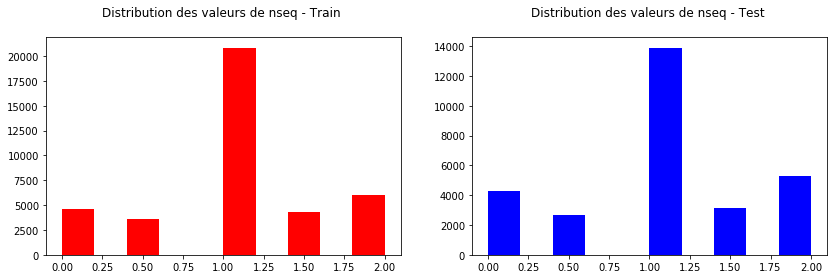

In [17]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.hist(df_mess_train.nseq, color='red')
plt.title("Distribution des valeurs de nseq - Train \n")
plt.subplot(122)
plt.hist(df_mess_test.nseq, color='blue')
plt.title("Distribution des valeurs de nseq - Test \n")
plt.show()

> Nous avons donc ici des valeurs catégorielles avec une distribution assez similaire entre le jeu d'entraînement et celui de test.

#### `rssi`

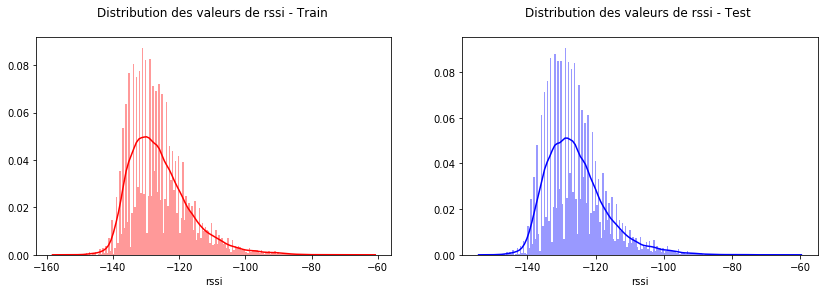

In [18]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.rssi, bins=200, color='red')
plt.title("Distribution des valeurs de rssi - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.rssi, bins=200, color='blue')
plt.title("Distribution des valeurs de rssi - Test \n")
plt.show()

> Là encore, la distribution semble équivalente entre le jeu d'entraînement et celui de test. 

#### `time_ux`

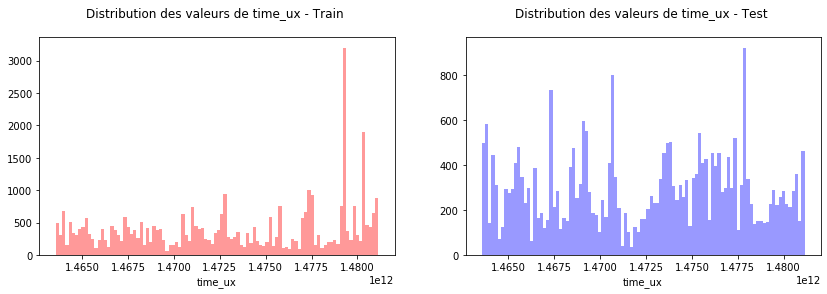

In [19]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.time_ux, bins=100, kde=False, color='red')
plt.title("Distribution des valeurs de time_ux - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.time_ux, bins=100, kde=False, color='blue')
plt.title("Distribution des valeurs de time_ux - Test \n")
plt.show()

> Les distributions sont ici différentes mais toutes deux comprises entre 1.4625 ms et 1.4825 ms.

#### `bsid`

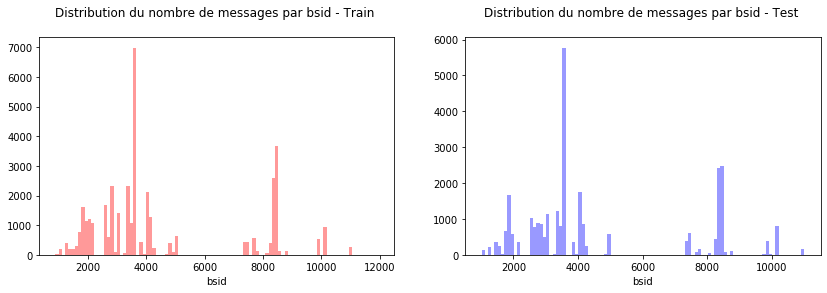

In [20]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.bsid, bins=100, kde=False, color='red')
plt.title("Distribution du nombre de messages par bsid - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.bsid, bins=100, kde=False, color='blue')
plt.title("Distribution du nombre de messages par bsid - Test \n")
plt.show()

> Il est ici à noter que certaines stations recoivent beaucoup plus de messages que d'autres. Cela sera donc à prendre en compte lors de l'analyse des catégories peu représentées. La distribution est en revanche similaire entre le jeu d'entraînement et celui de test.

#### `did`

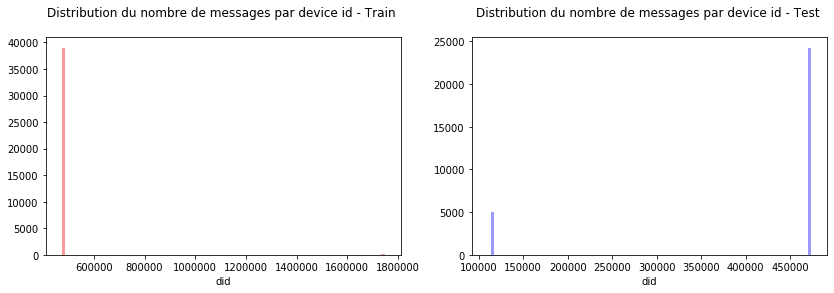

In [21]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df_mess_train.did, bins=100, kde=False, color='red')
plt.title("Distribution du nombre de messages par device id - Train \n")
plt.subplot(122)
sns.distplot(df_mess_test.did, bins=100, kde=False, color='blue')
plt.title("Distribution du nombre de messages par device id - Test \n")
plt.show()

> Il faut ici noter que les valeurs des id de devices sont très différentes. Il faudra donc regarder le nombre de messages par device_id et analyser les device_id peu représentés.

### 1.5 Corrélation entre variables
> Analysons ici les corrélations entre variables

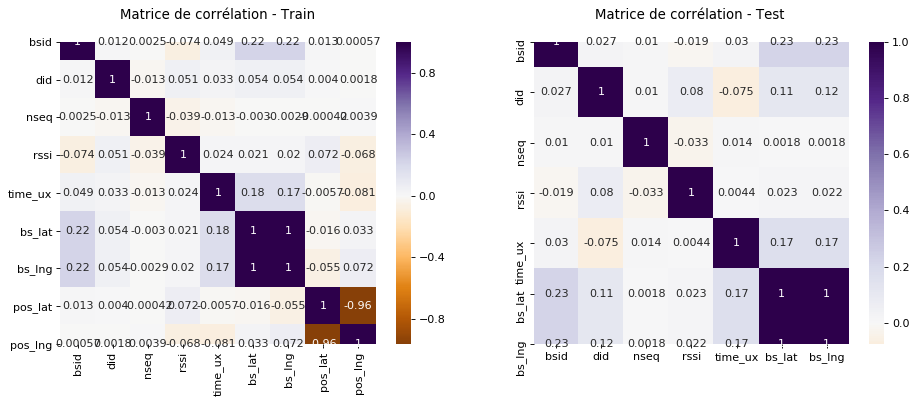

In [22]:
plt.figure(figsize=(14,5), dpi=80)
plt.subplot(121)
sns.heatmap(df_mess_train.corr(), cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Train\n', fontsize=12)
plt.subplot(122)
sns.heatmap(df_mess_test.corr(), cmap='PuOr', center=0, annot=True)
plt.title('Matrice de corrélation - Test \n', fontsize=12)
plt.show()

> On note donc qu'il n'y a pas de corrélations significatives entre variables, hormis entre la longitude et la lattitude des stations, mais cela était prévisible.

### 1.6 Détection de valeurs aberrantes
> Intéressons-nous ici aux valeurs aberrantes aussi nommées les *outliers*.

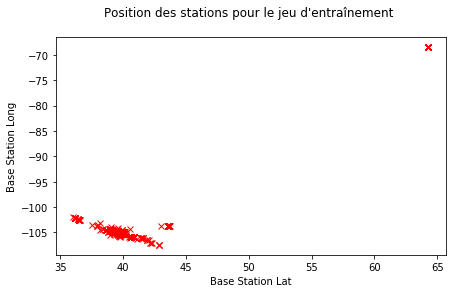

In [23]:
plt.figure(figsize=(7,4))
plt.plot(df_mess_train['bs_lat'], df_mess_train['bs_lng'], 'x', color='red')
plt.title('Position des stations pour le jeu d\'entraînement \n')
plt.xlabel('Base Station Lat')
plt.ylabel('Base Station Long')
plt.show()

> On constate donc ici que des stations sont éloignées des autres. Ces stations se trouvent à une longitude de -70 et une lattitude de 65. Voyons si cela se révèle aussi dans le jeu de test.

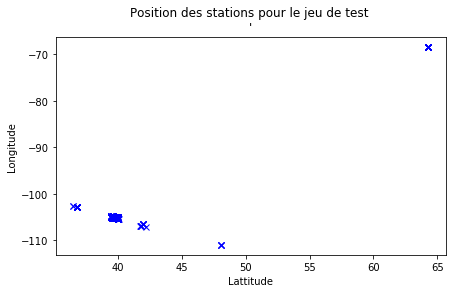

In [24]:
plt.figure(figsize=(7,4))
plt.plot(df_mess_test['bs_lat'], df_mess_test['bs_lng'], 'x', color='blue')
plt.title("Position des stations pour le jeu de test \n'")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")
plt.show()

> On constate que les stations isolées se trouvent également dans le jeu de test. Voyons toutefois si des messages semblent bien avoir été émis depuis des longitudes et lattitudes similaires.

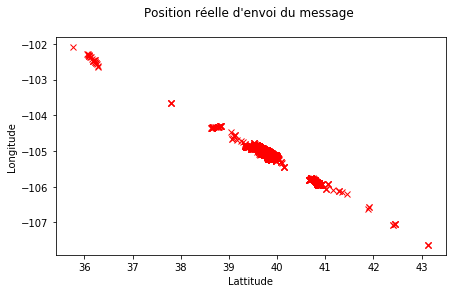

In [25]:
plt.figure(figsize=(7,4))
plt.plot(df_mess_train.pos_lat, df_mess_train.pos_lng, "x", color='red')
plt.title("Position réelle d'envoi du message \n")
plt.xlabel("Lattitude")
plt.ylabel("Longitude")
plt.show()

> Il est donc ici clair qu'aucun message n'a été envoyé à des longitudes et lattitudes prochent de -70 et 65. En conséquence, nous en déduisons que les lattitudes et longitudes de ces stations sont erronnées et il convient de définir d'une stratégie pour traiter ces anomalies. 

> Voyons donc si le nombre de messages associé à ces stations est important.

In [26]:
# Base station ayant une latitude > 60
df_mess_train[df_mess_train['bs_lat']>60]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
5106,57617e1ef0fe6e0c9fd6eb06,8355,476606.0,1.5,-106.5,1.466007e+12,64.3,-68.5,39.778694,-104.977050
5118,576180cf3e952e04b3b41e5c,8355,476512.0,0.5,-111.5,1.466008e+12,64.3,-68.5,39.783396,-104.999821
5179,5761a161f0fe6e0c9fec42b9,8355,473683.0,0.0,-126.0,1.466016e+12,64.3,-68.5,39.803407,-105.019300
5216,57623817864fce5689ec33af,8355,473683.0,0.5,-127.0,1.466055e+12,64.3,-68.5,39.803738,-105.018997
5416,5763734c864fce5689a422f3,8355,476600.0,1.5,-123.0,1.466135e+12,64.3,-68.5,39.803101,-105.023292
...,...,...,...,...,...,...,...,...,...,...
39237,58485bd412f14360d78bebdb,4987,476207.0,1.5,-130.5,1.481137e+12,64.3,-68.5,39.778872,-105.019285
39238,58485bd412f14360d78bebdb,4993,476207.0,0.0,-132.0,1.481137e+12,64.3,-68.5,39.778872,-105.019285
39241,58485bd412f14360d78bebdb,10151,476207.0,1.0,-122.0,1.481137e+12,64.3,-68.5,39.778872,-105.019285
39242,58485bd412f14360d78bebdb,11007,476207.0,1.0,-121.0,1.481137e+12,64.3,-68.5,39.778872,-105.019285


In [27]:
# Base station ayant une latitude > 60
df_mess_train[df_mess_train['bs_lat']>60].describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,pos_lat,pos_lng
count,4389.000000,4.389000e+03,4389.000000,4389.000000,4.389000e+03,4.389000e+03,4389.0,4389.000000,4389.000000
mean,6144.622465,4.986286e+05,1.038847,-125.300828,1.476081e+12,6.430000e+01,-68.5,39.759422,-105.029877
std,3451.227827,1.690960e+05,0.601033,9.230369,4.015779e+09,5.272828e-12,0.0,0.072178,0.051676
min,1092.000000,4.732880e+05,0.000000,-142.000000,1.466007e+12,6.430000e+01,-68.5,39.537137,-107.066221
25%,2707.000000,4.741810e+05,1.000000,-132.000000,1.472799e+12,6.430000e+01,-68.5,39.707218,-105.047845
50%,4993.000000,4.763150e+05,1.000000,-127.000000,1.477406e+12,6.430000e+01,-68.5,39.773364,-105.028769
75%,10151.000000,4.768290e+05,1.500000,-120.500000,1.479316e+12,6.430000e+01,-68.5,39.792541,-105.018591
max,11951.000000,1.747448e+06,2.000000,-69.333333,1.481140e+12,6.430000e+01,-68.5,42.452279,-104.921795


In [28]:
list_bs_outliers = df_mess_train[df_mess_train['bs_lat']>60].bsid.unique()
list_bs_outliers

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123, 11951,  9784,  1092,  1854,  7248])

In [29]:
print('Nombre de message associé au bsid :\n', 
      df_mess_train[df_mess_train['bs_lat']>60].groupby('bsid').count()['messid']
      .sort_values(ascending=True))

print("\nNombre de message total associé aux bsid dont bs_lat > 60 : {} "
      .format(df_mess_train[df_mess_train['bs_lat']>60].groupby('bsid').count()['messid'].sum()))

Nombre de message associé au bsid :
 bsid
4959       1
10999      1
9784       1
4123       1
11951      1
2293       2
7248       9
1854      27
1092      32
8449      72
2943      90
8560     116
1772     121
4156     127
4987     147
1661     160
1743     169
2707     191
8451     193
4129     216
1796     249
11007    275
1594     290
10151    333
8355     480
4993     488
10162    597
Name: messid, dtype: int64

Nombre de message total associé aux bsid dont bs_lat > 60 : 4389 


> On a donc identifié les stations de bases (au nombre de 27) qui ont une position très suspectes par rapport aux autres stations. De plus, nous savons maintenant combien de messages sont associés à chacune de ces stations. Le nombre total de messages pour toutes les stations est assez significatif, environ 4 000 sur 39 000 au total, soit approximativement 10\%. Toutefois, ne sachant comment les traiter autrement qu'en les supprimant puisque nous ne pouvons pas trouver facilement la position exacte de ces stations, **nous décidons de les supprimer** malgré tout. Ceci nous permettra d'éviter d'induire en erreur notre algorithme et donc de fausser les prédicitons.

In [30]:
# On retire les données liées aux stations ayant une latitude > 60
index_to_remove1 = df_mess_train[df_mess_train['bs_lat']>60].index.values
df_mess_train = df_mess_train.drop(index_to_remove1)

### 1.7 Détection des classes peu représentées
> On va ici essayer de trouver les stations qui traitent peu de messages pour potentiellement les enlever du jeu d'entraînement afin de ne garder que les stations les plus représentatives et donc d'avoir les catégories les plus fiables pour réaliser des prédicitions.

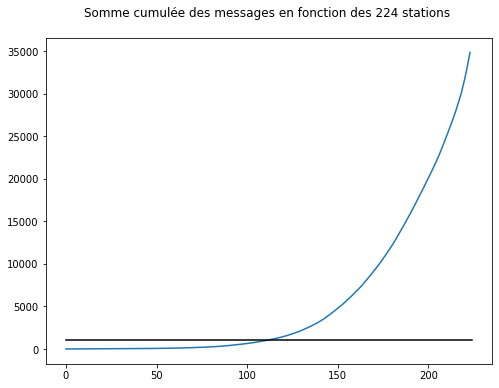

In [31]:
# On repère les base stations qui ne reçoivent pas beaucoup de messages
count_basestation = df_mess_train.groupby('bsid').count()
count_basestation = count_basestation['messid']
mes_limit = 1000 # limite en dessous de laquelle nous estimons les stations comme peu représentatives

plt.figure(figsize=(8,6))
count_basestation_cum = count_basestation.sort_values(ascending=True).cumsum()
plt.plot(count_basestation_cum.values)

x = [0, count_basestation_cum.count()]
y = [mes_limit, mes_limit]
plt.plot(x, y, color ='black')
plt.title("Somme cumulée des messages en fonction des {} stations \n".format(df_mess_train.bsid.nunique()), size=12)
plt.show()

In [32]:
print("Nombre de stations en dessous de la droite noire : {}".format((count_basestation_cum < mes_limit).sum()))

Nombre de stations en dessous de la droite noire : 111


> On constate donc qu'il y a 111 stations qui recoivent peu de messages mais qu'ensuite, les autres en recoivent significativement plus. **Nous décidons donc de retirer les stations recevant peu de messages des features qui seront utilisées pour entraîner notre modèle.**

In [33]:
# Les bsid qui ne reçoivent pas beaucoup de messages sont retirés des données d'entraînement
bsid_to_remove = count_basestation_cum[count_basestation_cum < mes_limit].index.values
index_to_remove2 = df_mess_train[df_mess_train.bsid.isin(bsid_to_remove)].index.values
df_mess_train = df_mess_train.drop(index_to_remove2)

In [34]:
# Réinitialisation des index pour faciliter les jointures des dataframes par la suite
n_train = df_mess_train.shape[0]
df_mess_train = df_mess_train.set_index(np.arange(n_train))

---
## **2. Features engineering**

### **2.1 Catégorisation des stations**

In [35]:
# On concatène le df d'entraînement et celui de test
df_concat = df_mess_train.iloc[:,:-2].append(df_mess_test, sort=False, ignore_index=True)
df_concat.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,63165.000000,6.316500e+04,63165.000000,63165.000000,6.316500e+04,63165.000000,63165.000000
mean,4474.790707,4.491625e+05,1.043719,-125.770830,1.472690e+12,40.974847,-103.287230
std,2468.817224,1.170454e+05,0.583078,9.051807,5.367785e+09,5.273846,7.862590
min,1012.000000,1.103350e+05,0.000000,-155.000000,1.463542e+12,36.528704,-110.957181
25%,2799.000000,4.725040e+05,1.000000,-132.000000,1.467961e+12,39.743521,-105.077530
50%,3559.000000,4.737960e+05,1.000000,-127.000000,1.472836e+12,39.779908,-105.047757
75%,7382.000000,4.763270e+05,1.500000,-121.000000,1.477408e+12,39.810509,-105.010048
max,11007.000000,1.747448e+06,2.000000,-63.000000,1.481143e+12,64.300000,-68.500000


In [36]:
# On détermine tous les stations prises en compte dans le jeu d'entraînement, après suppression 
# des stations peu représentées et aberrantes, ainsi que celles dans le jeu de test
listOfBs = df_concat.bsid.unique()
listNameBs = ["bs"+str(i+1) for i in range(len(listOfBs))]

In [37]:
print("Nombre de stations finales prises en compte : ", df_concat.bsid.nunique())

Nombre de stations finales prises en compte :  172


In [38]:
# OneHotEncoder pour BSID
ohe = OneHotEncoder()
X_bsid = ohe.fit_transform(df_concat[['bsid']]).toarray()

df_bsid_train = pd.DataFrame(X_bsid[:n_train,:], columns = listNameBs)
df_bsid_test = pd.DataFrame(X_bsid[n_train:,:], columns = listNameBs)

In [39]:
# On rajoute les colonnes de notre encodeur à nos dataset d'entraînement et celui de test
df_mess_train[listNameBs] = df_bsid_train
df_mess_test[listNameBs] = df_bsid_test

### **2.2 Catégorisation du device ID**
> On va faire de même que précédemment avec cette fois le `did`.

In [40]:
listOfDid = df_concat.did.unique()
listNameDid = ["did"+str(i+1) for i in range(len(listOfDid))]

In [41]:
print("Nombre de devices ID final pris en compte au final: ", len(listOfDid))

Nombre de devices ID final pris en compte au final:  168


In [42]:
# OneHotEncoder pour DID
ohe = OneHotEncoder()
X_did = ohe.fit_transform(df_concat[['did']]).toarray()

df_did_train = pd.DataFrame(X_did[:n_train,:], columns = listNameDid)
df_did_test = pd.DataFrame(X_did[n_train:,:], columns = listNameDid)

In [43]:
# On rajoute les colonnes de notre encodeur à nos dataset d'entraînement et celui de test
df_mess_train[listNameDid] = df_did_train
df_mess_test[listNameDid] = df_did_test

### **2.3 On groupe par `messid`**

In [73]:
df_grouped_train = df_mess_train.groupby(['messid'])
df_grouped_test = df_mess_test.groupby(['messid'])

#### Regroupement des `bsid` par `messid`

In [45]:
# On récupère tous les stations concernées par un messid donné
df_bsid_grouped_train = df_grouped_train.sum()[listNameBs]
df_bsid_grouped_test = df_grouped_test.sum()[listNameBs]

In [46]:
df_bsid_grouped_train.head()

,bs1,bs2,bs3,bs4,bs5,bs6,bs7,bs8,bs9,bs10,...,bs163,bs164,bs165,bs166,bs167,bs168,bs169,bs170,bs171,bs172
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_bsid_grouped_train.loc[['573bf1d9864fce1a9af8c5c9']].sum(axis=1)

messid
573bf1d9864fce1a9af8c5c9    2.0
dtype: float64

#### Nombre de `bsid` par `messid`

In [48]:
# On crée la variable du nombre total de bsid par message
count_bsid_grouped_train = df_bsid_grouped_train.sum(axis=1).values
count_bsid_grouped_test = df_bsid_grouped_test.sum(axis=1).values

#### Regroupement des `did` par `messid`

In [49]:
# On récupère tous les devices concernées par un messid donné
df_did_grouped_train = df_grouped_train.mean()[listNameDid]
df_did_grouped_test = df_grouped_test.mean()[listNameDid]

In [50]:
df_did_grouped_train

,did1,did2,did3,did4,did5,did6,did7,did8,did9,did10,...,did159,did160,did161,did162,did163,did164,did165,did166,did167,did168
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848551912f14360d786ede6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485a25e541cd0e1329b8d6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485bd412f14360d78bebdb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **2.4 Sélection de features**
> On commmence par rassembler sous forme d'un dataframe le group by `messid` que nous avons fait. Nous choisissons ici de moyenner les différentes variables pour un même message.

In [74]:
df_grouped_train = df_grouped_train.agg({'rssi':['mean'], 'bs_lat':['mean'], 'bs_lng':['mean'], 
                                          'time_ux':['mean'], 'pos_lat':['mean'], 'pos_lng':['mean']})
# On renomme les premières colonnes
df_grouped_train.columns = ['mean_rssi', 'mean_bs_lat', 'mean_bs_lng', 'mean_time_ux', 
                            'mean_pos_lat', 'mean_pos_lng']

# On rajoute les variables catégorielles que nous avons obtenus ci-avant
df_grouped_train[listNameBs] = df_bsid_grouped_train
df_grouped_train[listNameDid] = df_did_grouped_train


# On réinitialise l'index 
df_grouped_train = df_grouped_train.reset_index().drop(['messid'], axis=1)


In [75]:
# On crée notre dataframe d'entrainement avec les features qui nous intéressent
df_train = pd.DataFrame()
df_train[listNameBs] = df_grouped_train[listNameBs]
df_train[listNameDid] = df_grouped_train[listNameDid]
df_train['mean_rssi'] = df_grouped_train[['mean_rssi']]
df_train['mean_bs_lat'] = df_grouped_train[['mean_bs_lat']]
df_train['mean_bs_lng'] = df_grouped_train[['mean_bs_lng']]
df_train['mean_time_ux'] = df_grouped_train[['mean_time_ux']]
df_train['mean_pos_lat'] = df_grouped_train[['mean_pos_lat']]
df_train['mean_pos_lng'] = df_grouped_train[['mean_pos_lng']]

In [76]:
df_train

,bs1,bs2,bs3,bs4,bs5,bs6,bs7,bs8,bs9,bs10,...,did165,did166,did167,did168,mean_rssi,mean_bs_lat,mean_bs_lng,mean_time_ux,mean_pos_lat,mean_pos_lng
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-123.250000,39.647522,-104.953819,1.463546e+12,39.606690,-104.958490
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-134.000000,39.612745,-105.008827,1.463547e+12,39.637741,-104.958554
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-117.333333,39.751055,-105.001109,1.463553e+12,39.730417,-104.968940
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-127.416667,39.616885,-105.030503,1.463555e+12,39.693102,-105.006995
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-125.996032,39.778865,-105.033121,1.463586e+12,39.758167,-105.051016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-125.250000,39.766508,-104.997346,1.481135e+12,39.764915,-105.003985
5723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-129.566667,39.678859,-105.024327,1.481137e+12,39.658804,-105.008299
5724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-131.266667,39.780396,-105.022235,1.481137e+12,39.778872,-105.019285
5725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-126.000000,39.750901,-105.011496,1.481140e+12,39.773264,-105.014052


> On procède de même pour la partie test.

In [77]:
df_grouped_test = df_grouped_test.agg({'rssi':['mean'], 'bs_lat':['mean'], 'bs_lng':['mean'], 
                                          'time_ux':['mean']})
# On renomme les premières colonnes
df_grouped_test.columns = ['mean_rssi', 'mean_bs_lat', 'mean_bs_lng', 'mean_time_ux']

# On rajoute les variables catégorielles que nous avons obtenus ci-avant
df_grouped_test[listNameBs] = df_bsid_grouped_test
df_grouped_test[listNameDid] = df_did_grouped_test


# On réinitialise l'index 
df_grouped_test = df_grouped_test.reset_index().drop(['messid'], axis=1)


In [78]:
# On crée notre dataframe de test avec les features qui nous intéressent
df_test = pd.DataFrame()
df_test[listNameBs] = df_grouped_test[listNameBs]
df_test[listNameDid] = df_grouped_test[listNameDid]
df_test['mean_rssi'] = df_grouped_test[['mean_rssi']]
df_test['mean_bs_lat'] = df_grouped_test[['mean_bs_lat']]
df_test['mean_bs_lng'] = df_grouped_test[['mean_bs_lng']]
df_test['mean_time_ux'] = df_grouped_test[['mean_time_ux']]

In [79]:
df_test

,bs1,bs2,bs3,bs4,bs5,bs6,bs7,bs8,bs9,bs10,...,did163,did164,did165,did166,did167,did168,mean_rssi,mean_bs_lat,mean_bs_lng,mean_time_ux
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-111.000000,39.728651,-105.163032,1.463542e+12
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-126.125000,39.763474,-105.094321,1.463551e+12
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-128.250000,39.666322,-105.028319,1.463552e+12
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-113.000000,39.782113,-105.072701,1.463552e+12
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-129.208333,39.666322,-105.028319,1.463552e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-128.916667,45.885533,-95.847700,1.481133e+12
5290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-126.857143,46.784308,-94.587609,1.481133e+12
5291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-128.708333,39.656647,-105.043603,1.481134e+12
5292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-123.916667,39.660435,-105.060608,1.481138e+12


> On peut maintenant regarder quelles sont les features qui ont le plus d'importance sur un modèle `RandomForestRegressor`. Cela nous permettra d'affiner la sélection de nos variables et d'améliorer les performances d'entraînement de notre modèle.

In [80]:
X_train = df_train.iloc[:,:-2]
y_lat_train = df_train.mean_pos_lat
y_lng_train = df_train.mean_pos_lng

X_test = df_test

In [81]:
# Mise en place du RandomForest
clf_lat = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
clf_lat.fit(X_train, y_lat_train)

clf_lng = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
clf_lng.fit(X_train, y_lng_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [82]:
# Calcul de l'importance des features pour la latitude et la longitude
dict_feature_importance_lat = {'feature': X_train.columns.values, 
                               'importance': clf_lat.feature_importances_}
feature_importances_lat = pd.DataFrame(data=dict_feature_importance_lat).sort_values('importance', ascending=False)

dict_feature_importance_lng = {'feature': X_train.columns.values, 
                               'importance': clf_lng.feature_importances_}
feature_importances_lng = pd.DataFrame(data=dict_feature_importance_lng).sort_values('importance', ascending=False)

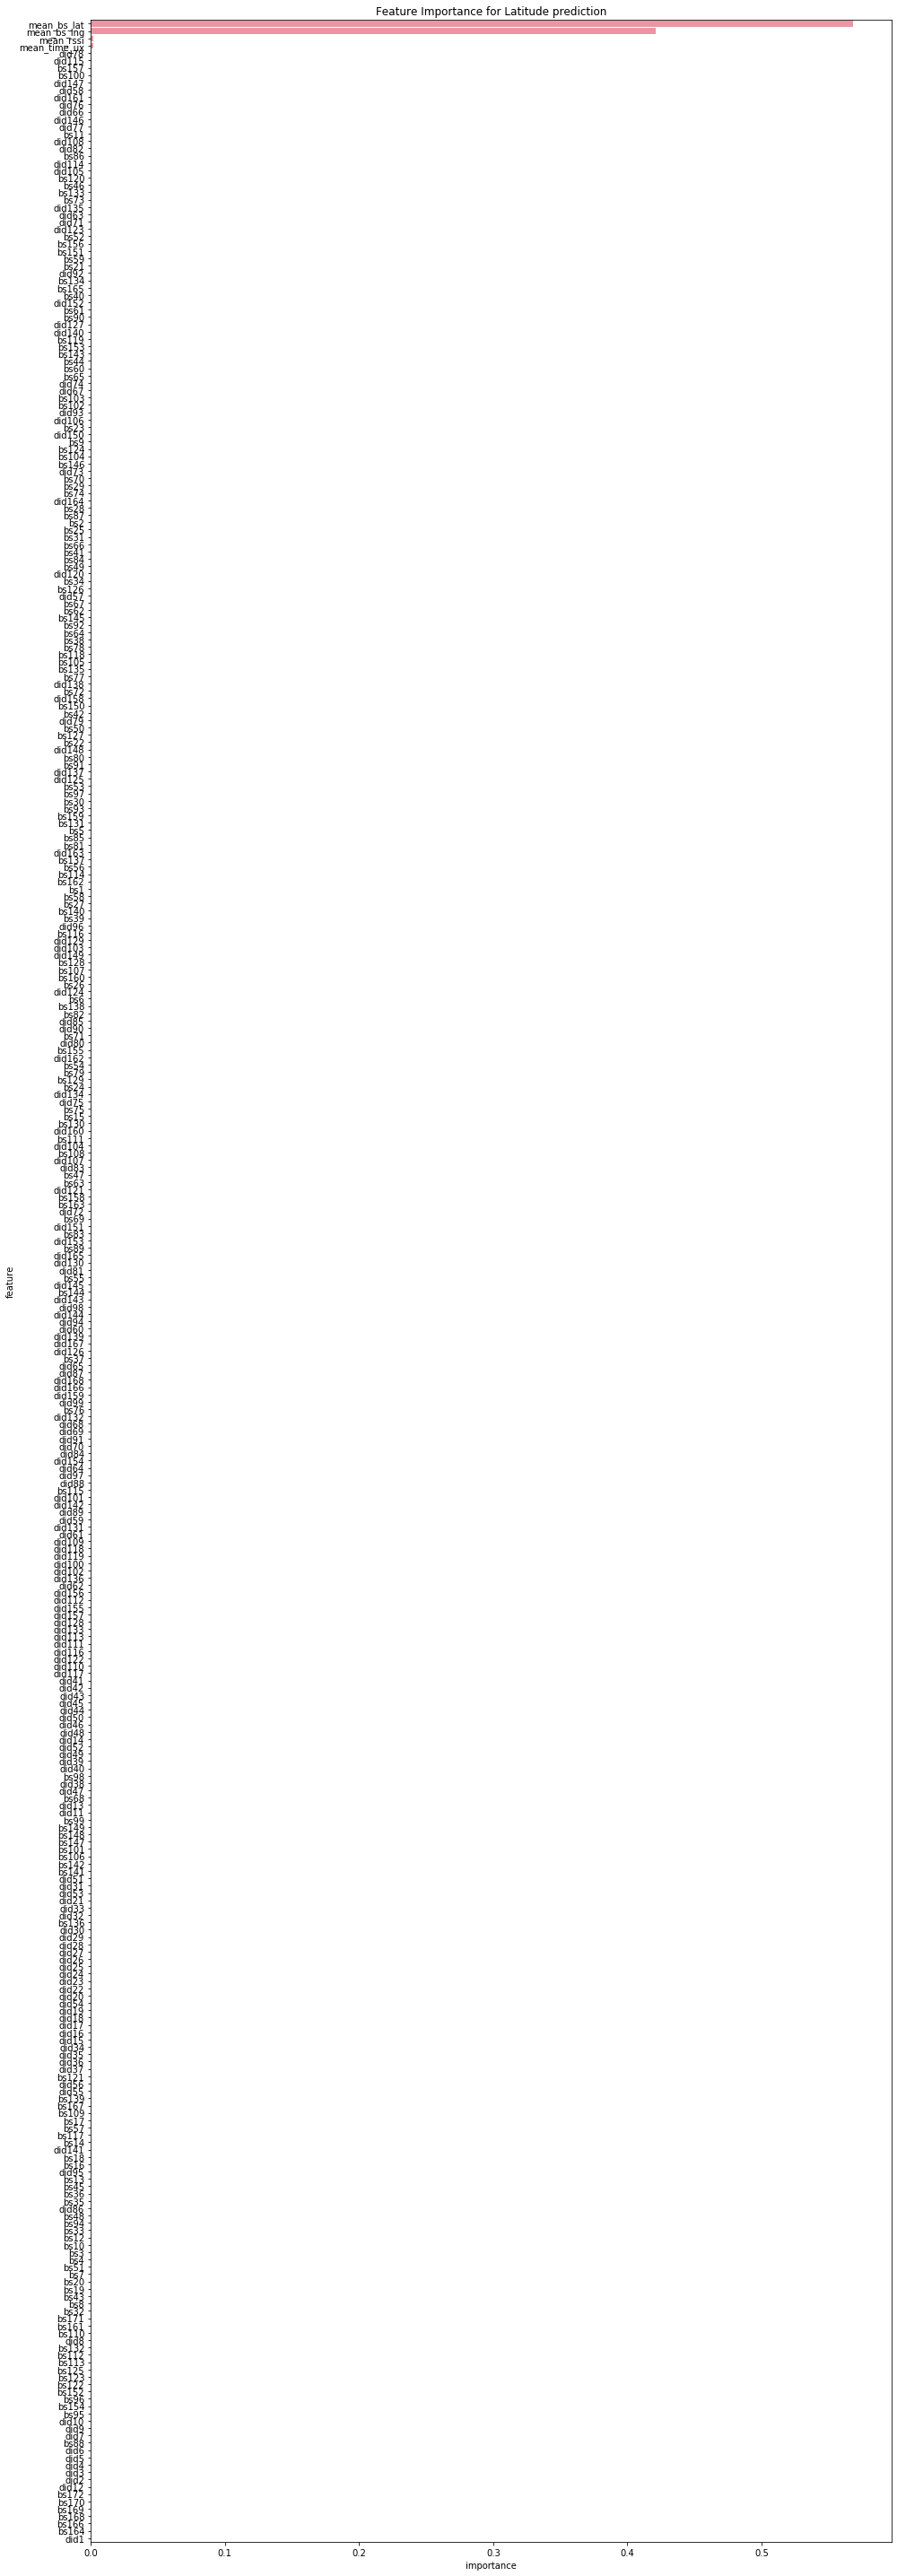

In [83]:
# On affiche les résultats pour la prédiction de la latitude
plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=feature_importances_lat.sort_values(by="importance",
                                                     ascending=False))
plt.title('Feature Importance for Latitude prediction')
plt.tight_layout()

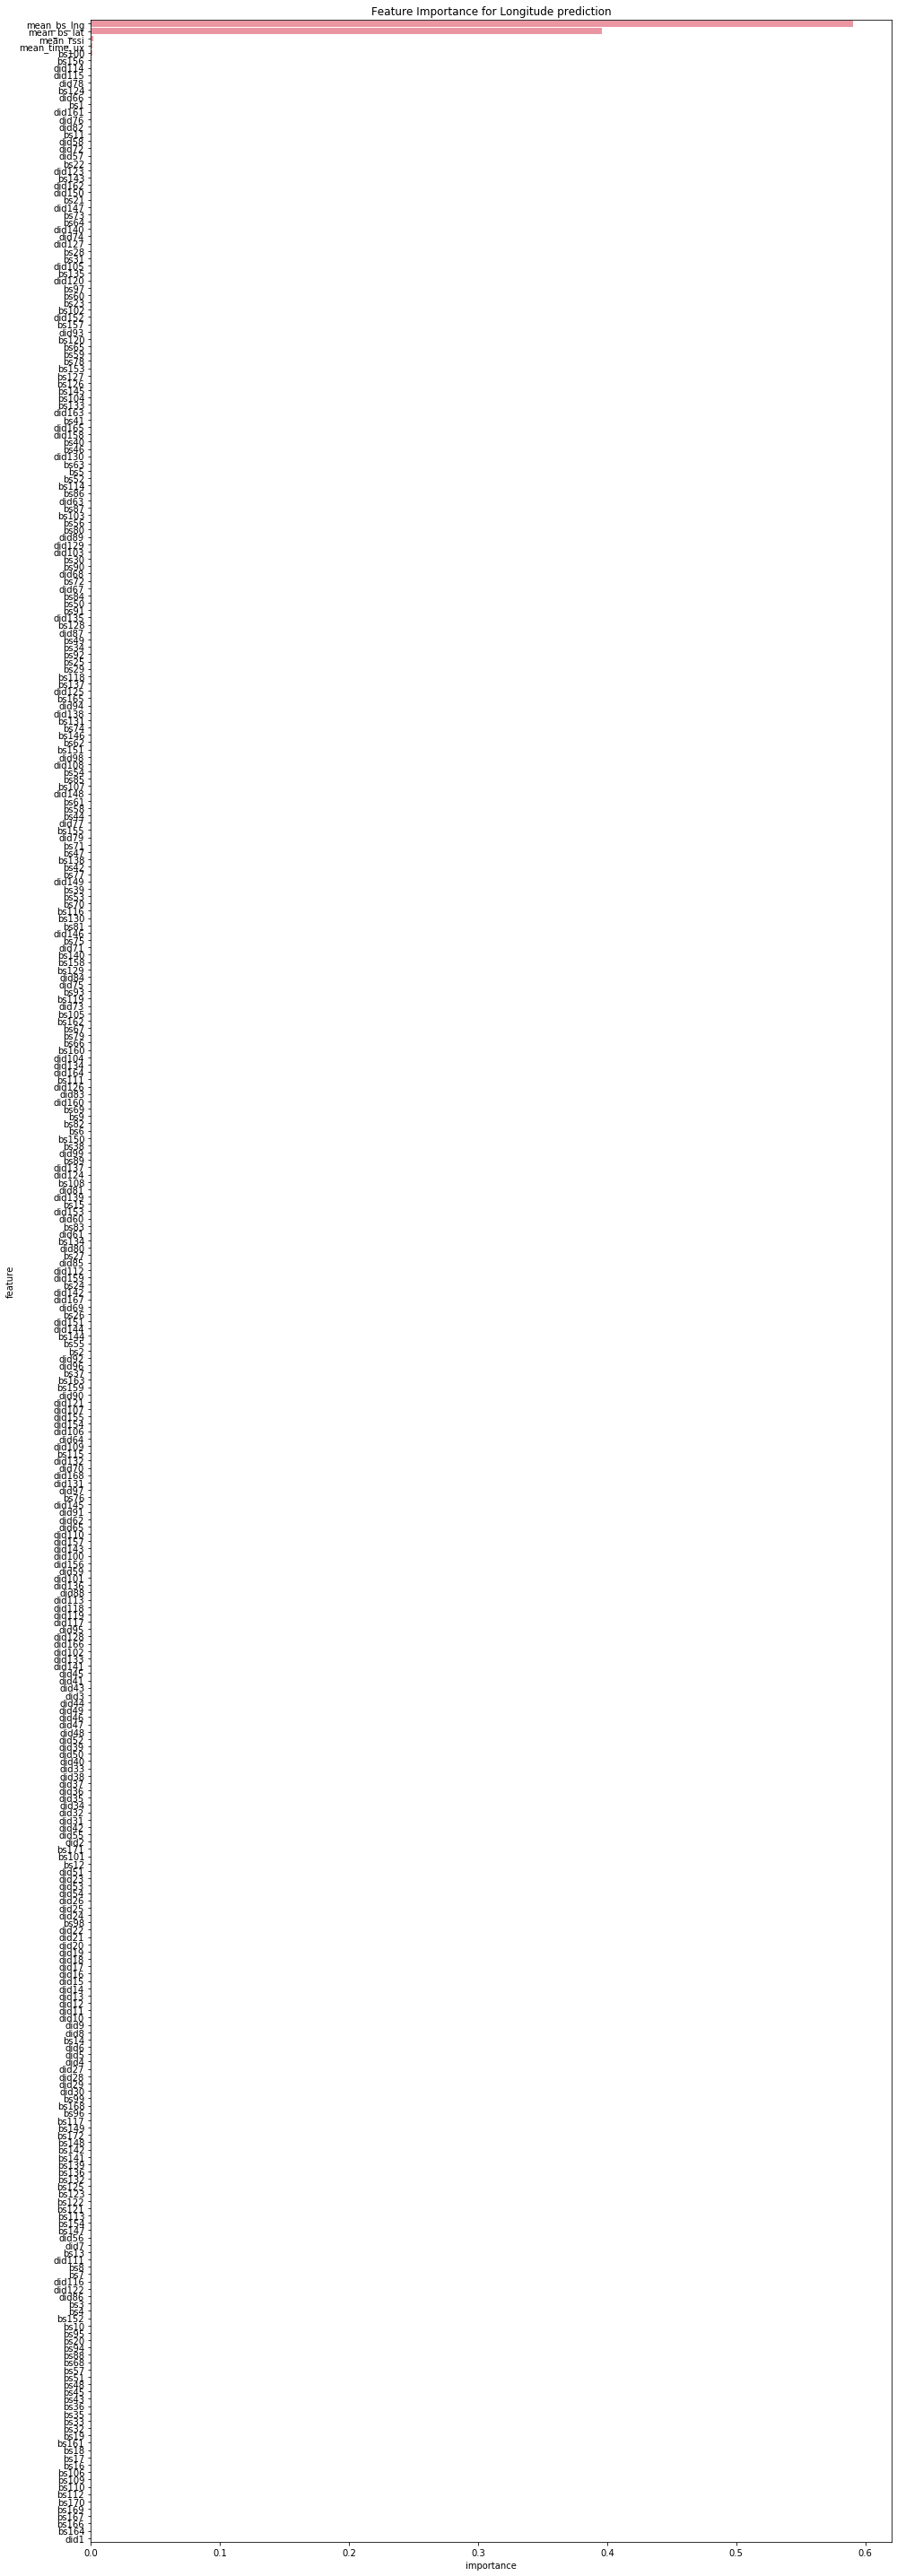

In [84]:
# On fait de même pour la prédiction de la longitude
plt.figure(figsize=(14,40))
sns.barplot(x="importance",
           y="feature",
           data=feature_importances_lng.sort_values(by="importance",
                                          ascending=False))
plt.title('Feature Importance for Longitude prediction')
plt.tight_layout()

> On remarque donc assez clairement que seules quelques variables ont une importance prépondérantes face aux autres. Nous allons donc retirer de nos jeux d'entraînement et de test les features dont l'importance est faible, c'est à dire au **seuil de 0.000025**.

In [85]:
seuil_importance = 0.000025

In [86]:
# On enlève les features avec importance faible
# on passe par set pour utiliser l'intersection des ensembles
masque_lat = feature_importances_lat['importance'] > seuil_importance
masque_lng = feature_importances_lng['importance'] > seuil_importance

index_to_remove3 = list(set(feature_importances_lat['feature'][np.logical_not(masque_lat)]
         ).intersection(set(feature_importances_lng['feature'][np.logical_not(masque_lng)])))
print("%d features ont une importance inférieure à %.6f." %(len(index_to_remove3), seuil_importance))
X_train = X_train.drop(index_to_remove3, axis=1)
X_test = X_test.drop(index_to_remove3, axis=1)

251 features ont une importance inférieure à 0.000025.


--- 
## **3. Modèles de prédiction**

In [87]:
# Fonction d'évaluation de nos résultats
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [88]:
# On prépare nos dataframe pour la cross-validation
Xtrain_cv, Xtest_cv, y_lat_train_cv, y_lat_test_cv, y_lng_train_cv, y_lng_test_cv = train_test_split(X_train,
                                                                                                     y_lat_train,
                                                                                                     y_lng_train,
                                                                                                     test_size=0.2,
                                                                                                     random_state=42)


### **3.1 Modèle `RandomForestRegressor`**
> On va maintenant optimiser notre algorithme de RandomForest. Pour cela, nous allons nous intéresser à la profondeur de l'arbre `max_depth`, à la proportion de features à considérer à chaque séparation de branches `max_features`, et au nombre destimateur `n_estimators`.

In [89]:
# Gridsearch manuel 
list_max_depth = [20, 25, 30, 35, 40, 45, 50]
list_max_features = [0.5, 0.6, 0.7, 0.8, 0.9, None]
list_n_estimators = [50, 100, 200]
  
err80 = 10000
list_result =[]
for max_depth in list_max_depth:
    print('\nEtape max_depth : '+str(max_depth))
    for max_features in list_max_features:
        #print(max_features)
        for n_estimators in list_n_estimators:
            #print(n_estimators)
            clf_rf_lat = RandomForestRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features, n_jobs=-1)
            clf_rf_lat.fit(Xtrain_cv, y_lat_train_cv)
            y_pred_lat = clf_rf_lat.predict(Xtest_cv) 

            clf_rf_lng = RandomForestRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features,n_jobs=-1)
            clf_rf_lng.fit(Xtrain_cv, y_lng_train_cv)
            y_pred_lng = clf_rf_lng.predict(Xtest_cv)

            err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)
            perc = np.percentile(err_vec, 80)
            list_result.append((max_depth,max_features,n_estimators, perc))
            if perc < err80: # distance erreur mini pour 80% des observations
                err80 = perc
                best_max_depth = max_depth
                best_max_features = max_features
                best_n_estimators = n_estimators    

print('--- Résultats finaux ---')
print('\nbest_max_depth', best_max_depth) 
print('best_max_features', best_max_features)
print('best_n_estimators', best_n_estimators)
print('err80', err80)


Etape max_depth : 20

Etape max_depth : 25

Etape max_depth : 30

Etape max_depth : 35

Etape max_depth : 40

Etape max_depth : 45

Etape max_depth : 50

best_max_depth 45
best_max_features 0.5
best_n_estimators 200
err80 2398.4268571952593


> Notre meilleur résultat est obtenu pour : 
* `max_depth` = 45
* `max_features` = 0.5
* `n_estimators` = 200

In [90]:
# On entraîne notre modèle RandomForest sur 80% du train set et on valide sur les 20% restants 
clf_rf_lat = RandomForestRegressor(n_estimators=best_n_estimators, max_features=best_max_features, 
                                   max_depth=best_max_depth, n_jobs=-1)
clf_rf_lat.fit(Xtrain_cv, y_lat_train_cv)
y_pred_lat = clf_rf_lat.predict(Xtest_cv) 

clf_rf_lng = RandomForestRegressor(n_estimators=best_n_estimators, max_features=best_max_features, 
                                   max_depth=best_max_depth, n_jobs=-1)
clf_rf_lng.fit(Xtrain_cv, y_lng_train_cv)
y_pred_lng = clf_rf_lng.predict(Xtest_cv)

err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)
print("Erreur de distance cumulée à 80% : {}" .format((np.percentile(err_vec, 80))))

Erreur de distance cumulé à 80% : 2510.7943856536035


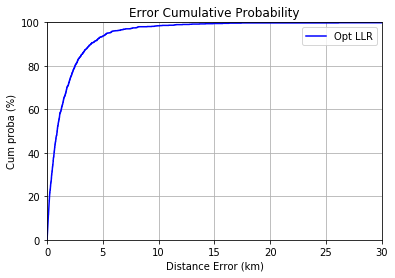

In [91]:
# On affiche le graphe des erreurs de distance cumulées
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

### **3.4 Modèle `ExtraTreesRegressor`**
> On teste ici une autre algorithme d'ensemble avec une nouvelle GridSearch.

In [92]:
# Gridsearch manuel (impossible d'utiliser les fonctions classiques car ici il y a 2 modèles à optimiser)
list_max_depth = [20, 25, 30, 35, 40, 45, 50, 55, 60]
list_max_features = [0.5, 0.6, 0.7, 0.8, 0.9, None]
list_n_estimators = [50, 100, 200]
  
err80 = 10000
list_result =[]
for max_depth in list_max_depth:
    print('\nEtape max_depth : '+str(max_depth))
    for max_features in list_max_features:
        #print(max_features)
        for n_estimators in list_n_estimators:
            #print(n_estimators)
            clf_et_lat = ExtraTreesRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features, n_jobs=-1)
            clf_et_lat.fit(Xtrain_cv, y_lat_train_cv)
            y_pred_lat = clf_et_lat.predict(Xtest_cv) 

            clf_et_lng = ExtraTreesRegressor(n_estimators = n_estimators, max_depth=max_depth,
                                               max_features = max_features,n_jobs=-1)
            clf_et_lng.fit(Xtrain_cv, y_lng_train_cv)
            y_pred_lng = clf_et_lng.predict(Xtest_cv)

            err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)
            perc = np.percentile(err_vec, 80)
            list_result.append((max_depth,max_features,n_estimators, perc))
            if perc < err80: # distance erreur mini pour 80% des observations
                err80 = perc
                best_max_depth = max_depth
                best_max_features = max_features
                best_n_estimators = n_estimators    

print('--- Résultats finaux ---')               
print('\nbest_max_depth', best_max_depth) 
print('best_max_features', best_max_features)
print('best_n_estimators', best_n_estimators)
print('err80', err80)


Etape max_depth : 20

Etape max_depth : 25

Etape max_depth : 30

Etape max_depth : 35

Etape max_depth : 40

Etape max_depth : 45

Etape max_depth : 50

Etape max_depth : 55

Etape max_depth : 60

best_max_depth 35
best_max_features 0.7
best_n_estimators 200
err80 2362.6160682919167


> Notre meilleur résultat est obtenu pour : 
* `max_depth` = 30
* `max_features` = 0.6 
* `n_estimators` = 50

In [93]:
# On entraîne notre modèle Extratrees sur 80% du train set et on valide sur les 20% restants 
clf_lat = ExtraTreesRegressor(n_estimators=best_n_estimators, max_features=best_max_features, 
                              max_depth=best_max_depth, n_jobs=-1)
clf_lat.fit(Xtrain_cv, y_lat_train_cv)
y_pred_lat = clf_lat.predict(Xtest_cv)
clf_lng = ExtraTreesRegressor(n_estimators=best_n_estimators, max_features=best_max_features, 
                              max_depth=best_max_depth, n_jobs=-1)
clf_lng.fit(Xtrain_cv, y_lng_train_cv)
y_pred_lng = clf_lng.predict(Xtest_cv)

err_vec = Eval_geoloc(y_lat_test_cv , y_lng_test_cv, y_pred_lat, y_pred_lng)
print("Erreur de distance cumulée à 80% : {}" .format((np.percentile(err_vec, 80))))

Erreur de distance cumulé à 80% : 2385.37321922266


> On est donc un peu meilleur avec cet algorithme et c'est naturellement celui-ci que nous retiendrons.

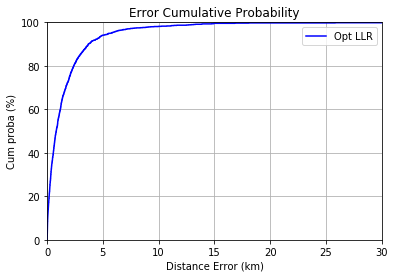

In [94]:
# On affiche le graphe des erreurs de distance cumulées
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

---
## **4. Construction du fichier de prédiction**

In [95]:
# On prédit sur le test set à partir de l'algorithme d'Extratrees entraîné précédemment
y_pred_lat_final = clf_lat.predict(X_test)
y_pred_lng_final = clf_lng.predict(X_test)

In [96]:
# Construction du fichier de prédiction
test_res = pd.DataFrame(np.array([y_pred_lat_final, y_pred_lng_final]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()

,lat,lng
0,39.765341,-105.131323
1,39.779037,-105.076767
2,39.695388,-105.019189
3,39.783742,-105.079556
4,39.696333,-105.018547


---
## **5. Construction d'un prédicteur avec en *leave one device out***